# Match the Time-Series Observations
Make the photometry tables of the same stars, in order to draw the light curve of the target.
You should input the observation date and the target name to **tape.par**.

- Match the same stars from all images by using the coordinate of star in the image.
- Give the unique numbers to the found stars.
- Make the photometry tables with the same rows(stars) for all images.


Read the parameters from **tape.par**.

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.io import fits 
from photlib import read_params, prnlog, sigma_clip
import shutil

# READ the parameter file
par = read_params()

# PARAMETERS for the list of time-series observation
WORKDIR = par['WORKDIR']
SHIFT_PLOT = bool(int(par['SHIFTPLOT']))  # ON/OFF image shift plot
N_APER = len(par['PHOTAPER'].split(',')) # number of aperture in .apw file, photometry result
FWHM_CUT2 = np.array(par['FWHMCUT'].split(','),float)[1]
LOGFILE = par['LOGFILE']
OBSDATE = par['OBSDATE']
TARGETNAME = par['TARGETNAM']
WNAME = OBSDATE+'-'+TARGETNAME

prnlog(f"#WORK: make_timeseries")
prnlog(f"#WORK DIR: {WORKDIR}")
prnlog(f"#SHIFT PLOT: {SHIFT_PLOT}")
prnlog(f"#LOG FILE: {LOGFILE}")

# MOVE to the working directory =======
CDIR = os.path.abspath(os.path.curdir)
os.chdir(WORKDIR)
#======================================

c:\Users\kang\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#WORK: make_timeseries
#WORK DIR: ./180326-HAT-P-12b
#SHIFT PLOT: True
#LOG FILE: wobs.log


Read the observation log generated by **02-run_photometry.py**.

In [2]:
# READ log file and 
# SET the fiducial frame index and position 
# automatically find the first frame 
flog = open(LOGFILE,'r')
lfrm, lname, lJD, lX = [], [], [], [] 
for line in flog:
    tmp = line.split()
    lfrm.append(int(tmp[0]))
    lname.append(tmp[1])
    lJD.append(float(tmp[2]))
    lX.append(float(tmp[4]))
FNUM, FLIST, FJD, FX = np.array(lfrm), np.array(lname), np.array(lJD), np.array(lX)
flog.close()


Determine the reference frame for the rest of images, recommend to select the first image.

You should determine the number of stars for matching process.

In [4]:
# READ reference frame index and position
FID = FLIST[0]
dat = np.genfromtxt(FID+'.apw')
tx, ty = dat[:,0], dat[:,1] 
tnum = np.arange(1,len(tx)+1, dtype=int)
tmag = dat[:,(2*N_APER+2)]
# ------------------------------------------
# YOU SHOULD CUSTOMIZE THIS NUMBER OF STARS TO MATCH
# ------------------------------------------
NCUT = 47
# ------------------------------------------
tbb = np.argsort(tmag)[:NCUT]

Run the loop of all images. 
- Read the coordinate of all stars in the image 
- Find the closest star to each star in the referece frame 
- Find the (X, Y) shift of the image to the reference frame with median filter 
- Refind the closest stars to the reference stars 
- Write the photometry result to the new file in order of the reference stars (.apx file)

In [5]:

fmat = open('wmatching.log', 'w')
jds, xs, ys, alts, azis, decs = [FJD[0],], [0,], [0,], [0,], [0,], [0,]
# LOOP for apw files
for i, fidx in enumerate(FLIST):

    # READ the FITS header 
    hdu = fits.open(fidx+'.fits')
    img, hdr = hdu[0].data, hdu[0].header
    EXPTIME = float(hdr.get('EXPTIME'))
    FILTER = hdr.get('FILTER')
    HJD = FJD[i]
    ALT = float(hdr.get('ALT'))
    AZI = float(hdr.get('AZ'))
    try:
        DEC = float(hdr.get('DEC'))
    except:
        DEC = 0
    AIRMASS = FX[i]

    # READ the apw file with number and index of apertures 
    dat = np.genfromtxt(fidx+'.apw')
    if len(dat.shape) < 2:
        continue
    
    # READ all coordiates ------------------------------------------
    xpix, ypix = dat[:,0], dat[:,1] 
    # READ brightness data 
    mag = dat[:,(2*N_APER+2)]

    # FILTERING coordinates of bright stars by magnitude-limits
    vv = np.argsort(mag)[:NCUT]
    xpix2, ypix2 = xpix[vv], ypix[vv]
    
    dx, dy = [], [] 
    for inum, ix, iy in zip(tnum[tbb], tx[tbb], ty[tbb]):
        rsq = (ix - xpix2)**2 + (iy - ypix2)**2 
        mm = np.argmin(rsq)
        dx.append(ix - xpix2[mm])
        dy.append(iy - ypix2[mm])
    # CALC. the median of shifts
    xmed, xsig = np.median(dx), np.std(dx)
    ymed, ysig = np.median(dy), np.std(dy)
    
    # PLOT the shift result in the image 
    if SHIFT_PLOT:
        fig, ax = plt.subplots(num=1, figsize=(8,8), dpi=100)
        ny, nx = img.shape
        iavg, imed, istd = sigma_clip(img)
        z1, z2 = imed, imed+istd*8
        ax.imshow(-img, vmin=-z2, vmax=-z1, cmap='gray')
        ax.scatter(xpix, ypix, 100,facecolors='none', edgecolor='b', alpha=0.7)
        ax.plot(tx-xmed, ty-ymed, 'r+', mew=1, ms=18, alpha=0.7, label=f'dx={xmed:.3f}, dy={ymed:.3f}')
        ax.set_xlim(0,nx)
        ax.set_ylim(ny,0)
        ax.set_title('Shift of Image: '+fidx, fontsize=15)
        ax.legend(loc='upper right', fontsize=15)
        fig.savefig(fidx+'-matching')
        fig.clf()
    
    prnlog(f'{fidx} dx={xmed:.2f}({xsig:.2f}) dy={ymed:.2f}({ysig:.2f}) {len(dx):d}/{len(tbb):d}')
    fmat.write(f'{fidx} {xmed:8.3f} {xsig:6.3f} {ymed:8.3f} {ysig:6.3f} {len(dx):d}\n')
    jds.append(HJD)
    xs.append(xmed)
    ys.append(ymed)
    alts.append(ALT)
    azis.append(AZI)
    decs.append(DEC)

    # SAVE photometry result of the same star on the same row
    fdat = open(fidx+'.apx', 'w')         
    for i, ix, iy in zip(tnum, tx, ty):
        rsq = (ix - xpix - xmed)**2 + (iy - ypix - ymed)**2 
        mm = np.argmin(rsq)
        if rsq[mm] > FWHM_CUT2**2:
            flag = 99
        else:
            flag = 0
        fstr = f'{i:03.0f} {xpix[mm]:10.3f} {ypix[mm]:10.3f} '
        fstr1, fstr2, fstr3, fstr4 = '', '', '', ''
        for k in range(N_APER):
            fstr1 = fstr1 + '%12.3f ' % (dat[mm,(k+2)],)
            fstr2 = fstr2 + '%12.3f ' % (dat[mm,(N_APER+k+2)],)
            fstr3 = fstr3 + '%8.3f ' % (dat[mm,(2*N_APER+k+2)],)
            fstr4 = fstr4 + '%8.3f ' % (dat[mm,(3*N_APER+k+2)],)
        fstr += fstr1 + fstr2 + fstr3 + fstr4 
        fstr += '%12.3f %i \n' % (rsq[mm], flag) 
        fdat.write(fstr)
    fdat.close()            

fmat.close()
plt.close('all')

wobject-000115 dx=0.00(0.00) dy=0.00(0.00) 22/22
wobject-000116 dx=-0.43(23.96) dy=-1.02(24.23) 22/22
wobject-000117 dx=-0.50(39.61) dy=-2.29(48.49) 22/22
wobject-000118 dx=-0.78(27.66) dy=-3.60(25.10) 22/22
wobject-000121 dx=-2.40(0.12) dy=-8.69(0.08) 22/22
wobject-000124 dx=2.01(0.13) dy=6.56(0.14) 22/22
wobject-000127 dx=0.22(0.17) dy=3.07(0.09) 22/22
wobject-000130 dx=-1.14(0.14) dy=0.57(0.10) 22/22
wobject-000131 dx=-2.04(0.22) dy=0.09(0.11) 22/22
wobject-000132 dx=-2.50(0.23) dy=-0.66(0.09) 22/22
wobject-000133 dx=-3.02(0.21) dy=-1.29(0.09) 22/22
wobject-000134 dx=-3.75(19.72) dy=-2.07(23.69) 22/22
wobject-000135 dx=-4.68(10.75) dy=-2.45(22.36) 22/22
wobject-000136 dx=-5.77(0.17) dy=1.34(0.08) 22/22
wobject-000137 dx=-6.35(0.16) dy=0.66(0.11) 22/22
wobject-000138 dx=-6.99(0.18) dy=-0.03(0.11) 22/22
wobject-000139 dx=-0.85(0.16) dy=-0.37(0.07) 22/22
wobject-000141 dx=-2.87(0.19) dy=-1.59(0.09) 22/22
wobject-000143 dx=-4.94(0.19) dy=-2.32(0.07) 22/22
wobject-000145 dx=-3.48(0.22) d

Plot the shift map along the time 

#SHIFT PLOT: JD(2458204.091072 - 0.184084)
WRITE TO w180326-HAT-P-12b-shift.png...


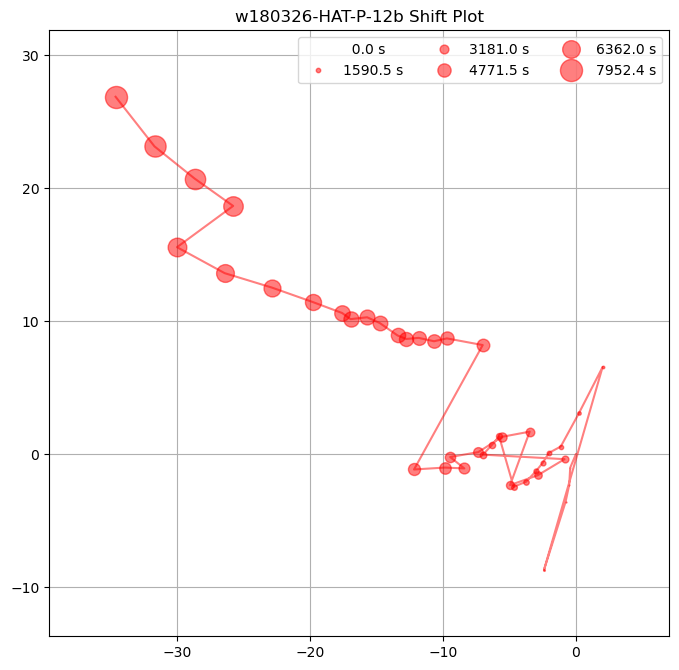

In [7]:
# PLOT the shift map
fig, ax = plt.subplots(num=2, figsize=(8,8), dpi=100)
ax.plot(xs, ys, 'r-', alpha=0.5)
fout = open(f'w{WNAME}-shift.txt', 'w')
num = range(len(xs))
jd0 = jds[0]
djd = jds[-1] - jd0
prnlog(f'#SHIFT PLOT: JD({jd0:.6f} - {djd:.6f})')
for p1, p2, p3, p4, p5, p6, p7 in zip(num, xs, ys, jds, alts, azis, decs):
    fout.write(f'{p1:4.0f} {p4:20.8f} {p2:8.3f} {p3:8.3f} {p5:8.3f} {p6:8.3f} {p7:8.3f}\n')
    ax.plot(p2, p3, 'ro', ms=((p4-jd0)*(3600*12)/500.), alpha=0.5) 
fout.close()
for i in np.linspace(0,djd*3600*12,6):
    ax.plot(-200,200,'ro',ms=(i/500.), alpha=0.5, label=f'{i:5.1f} s')
ax.set_xlim(min(xs)-5,max(xs)+5)
ax.set_ylim(min(ys)-5,max(ys)+5)
ax.set_aspect(1)
ax.grid()
ax.legend(fontsize=10,loc='upper right', ncol=3, numpoints=1)
ax.set_title(f'w{WNAME} Shift Plot')
prnlog(f'WRITE TO w{WNAME}-shift.png...')
fig.savefig(f'w{WNAME}-shift.png')

Plot the finding chart of the stars with the unique numbers

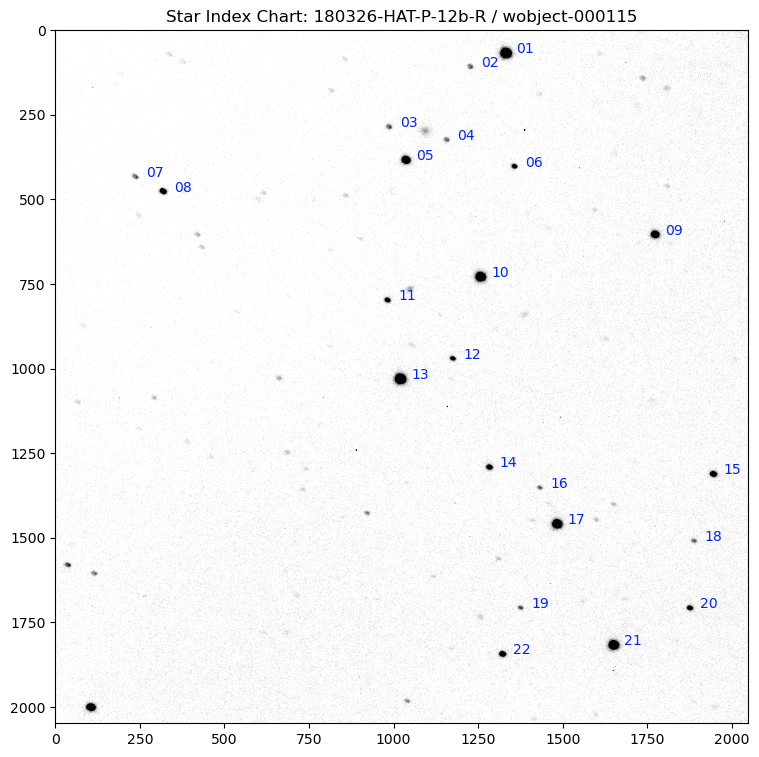

In [8]:
# READ AND PLOT the finding-chart
hdu = fits.open(FID+'.fits')
img, hdr = hdu[0].data, hdu[0].header
ny, nx = img.shape
fig, ax = plt.subplots(num=3, figsize=(9,9), dpi=100)
iavg, imed, istd = sigma_clip(img)
z1, z2 = imed, imed+istd*8
ax.imshow(-img, vmin=-z2, vmax=-z1, cmap='gray')
tpp = np.argsort(tmag)[:200]
# LOOP for the bright stars 
for ix, iy, inum in zip(tx[tpp], ty[tpp], tnum[tpp]):
    ax.text(ix+30, iy, '%02i' % (inum,), fontsize=10, color='#0022FF')
ax.set_xlim(0,nx)
ax.set_ylim(ny,0)
ax.set_title(f'Star Index Chart: {WNAME}-{FILTER} / {FID}')
fig.savefig(f'w{WNAME}-chart.png')


Return to the directory

In [ ]:
# RETURN to the directory ===========
os.chdir(CDIR) 
#====================================

Find the target and write the number of target to **tape.par**

>TARGETNUM 13           # (TIMESERIES) target star numbers in finding-chart